In [1]:
# setup help from G2Net TF Dataset Starter at https://www.kaggle.com/vincentdumetz/g2net-tf-dataset-starter

In [41]:
import os
import time
import random

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [49]:
import torch
from torch import nn
from torchvision.models import resnet18
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend("soundfile")

In [42]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

In [45]:
BASE_PATH = 'E:\\GravitationalWaveDetection\\'
SPLIT_RATIO = .9
RANDOM_STATE = 69
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
set_seed(RANDOM_STATE)

In [7]:
def apply_raw_path(row, is_train=True): 
    file_name = row[0]
    if is_train:
        return os.path.join(
            BASE_PATH, 'train',
            file_name[0],
            file_name[1],
            file_name[2],
            file_name + ".npy")
    else:
        return os.path.join(
            BASE_PATH, 'test',
            file_name[0],
            file_name[1],
            file_name[2],
            file_name + ".npy")

In [8]:
df = pd.read_csv(os.path.join(BASE_PATH, 'training_labels.csv'))
# df = df.sample(frac=1, random_state=RANDOM_STATE)
df['file_path'] = df.apply(apply_raw_path, args=(True,), axis=1)
df['target'] = df['target'].astype('int8')
df.head()

,id,target,file_path
0,00000e74ad,1,E:\GravitationalWaveDetection\train\0\0\0\0000...
1,00001f4945,0,E:\GravitationalWaveDetection\train\0\0\0\0000...
2,0000661522,0,E:\GravitationalWaveDetection\train\0\0\0\0000...
3,00007a006a,0,E:\GravitationalWaveDetection\train\0\0\0\0000...
4,0000a38978,1,E:\GravitationalWaveDetection\train\0\0\0\0000...


In [9]:
def plot_samples(sample_list):
    fig,a =  plt.subplots(len(sample_list), 3, figsize=(15,2 * len(sample_list)))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.2)
    cpt = 0
    for sample_num in sample_list:
        sample = np.load(df.loc[sample_num]['file_path'])
        a[cpt, 0].plot(sample[0],color='red')
        a[cpt, 1].plot(sample[1],color='green')
        a[cpt, 2].plot(sample[2],color='cyan')
        a[cpt, 1].set_title(
            'sample ' + str(sample_num) +
            ', label ' + str(df.loc[sample_num]['target']),
            fontsize=16
        )
        cpt = cpt + 1
    plt.show()
    return sample.shape

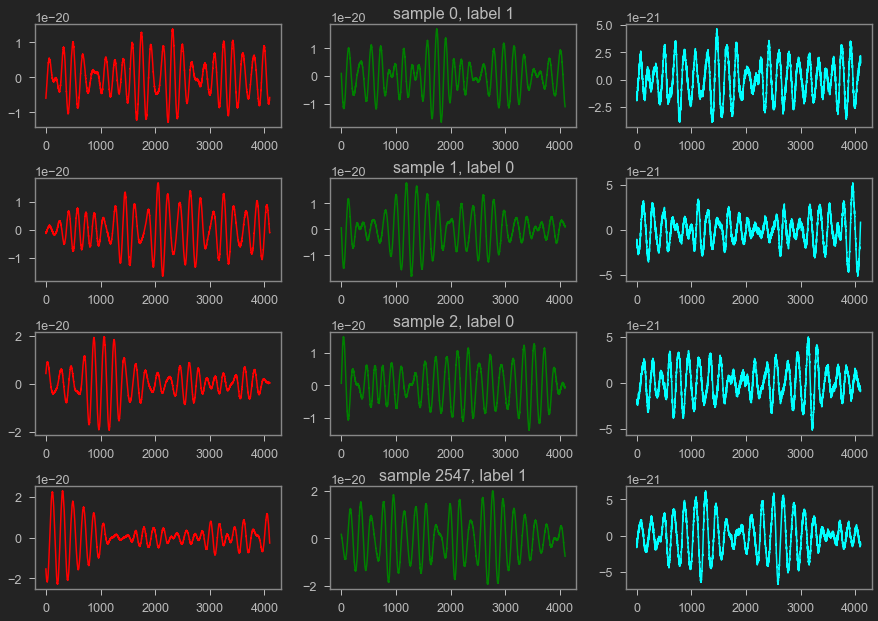

(3, 4096)

In [10]:
samples = [0, 1, 2, 2547]
plot_samples(samples)

In [11]:
print("Sample shape: ",str(np.load(df.loc[2547]['file_path']).shape))
print("Number of records:", str(len(df)))

Sample shape:  (3, 4096)
Number of records: 560000


In [12]:
df_train, df_val = train_test_split(
    df,
    train_size = SPLIT_RATIO,
    test_size = 1 - SPLIT_RATIO,
    random_state = RANDOM_STATE
)

print(len(df_train))
print(len(df_val))
print(f'-----------------\n' \
      f'{df_train.loc[0]}')

504000
56000
-----------------
id                                                  00000e74ad
target                                                       1
file_path    E:\GravitationalWaveDetection\train\0\0\0\0000...
Name: 0, dtype: object


In [26]:
waveform = torch.Tensor(np.load(df_train.file_path[0]))
print(f'tensor shape: {", ".join([str(i) for i in [*arr.shape]])}')

tensor shape: 3, 4096


In [27]:
spectrogram = T.Spectrogram(n_fft=128, hop_length=64)

In [46]:
spectrogram(waveform[0])

tensor([[1.0190e-38, 5.2213e-38, 2.5903e-41,  ..., 6.2827e-38, 4.3064e-39,
         1.8162e-37],
        [2.0811e-38, 2.9099e-38, 2.9839e-39,  ..., 6.8786e-38, 5.7936e-38,
         5.5441e-38],
        [1.2253e-38, 2.7249e-39, 7.8141e-40,  ..., 7.5879e-39, 8.2215e-39,
         2.1855e-41],
        ...,
        [6.5441e-43, 6.2918e-43, 1.5835e-43,  ..., 1.0608e-42, 1.3747e-42,
         9.0944e-43],
        [5.6893e-43, 2.7606e-43, 5.8995e-43,  ..., 6.3058e-44, 1.5470e-42,
         1.8217e-44],
        [1.6213e-42, 1.2612e-44, 4.2599e-43,  ..., 8.4078e-44, 8.7581e-43,
         7.4549e-43]])

In [37]:
df.target.mean()

0.499875

In [64]:
classes = torch.Tensor(df.target.unique())
model = resnet18(pretrained=True)
model.conv1=nn.Conv2d(1, model.conv1.out_channels, 
                      kernel_size=model.conv1.kernel_size[0], 
                      stride=model.conv1.stride[0], 
                      padding=model.conv1.padding[0])
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

In [65]:
train = df.sample(frac=1, random_state=RANDOM_STATE)
X = train.file_path
y = train.target
model.fit(torch.Tensor(X[0]), target[0])

ModuleAttributeError: 'ResNet' object has no attribute 'fit'